**team number:** 8

**team member:** Shangyin Gao, Hanbo Hu, Jia Hua, Siyuan Liu, Xianrui Niu

In [1]:
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

# Task2_1

In [70]:
def imgMat (subset_num):
    """
    return 2-D array each column vector = vectorized zero mean image
    number of row = number of image in this folder
    subset_num: from 0 to 4
    """
    # num of different person
    person_num = 10
    data_path = './yaleBfaces/subset'
    num = range(1, 65, 1)
    # this array store info about the start and stop number
    # e.g. for 1. folder num of sample start with 1 end with 8-1=7
    pic_start_stop = np.array([1, 8, 20, 32, 46, 65])
    prefix = data_path + str(subset_num) + '/person'
    suffix = '.png'
    file_name = []
    # path of every image in folder, save image name to array file_name
    # actually this big for loop can be done by import os
    for first_num in np.linspace(1, person_num, num = person_num, dtype = int):
        for second_num in range(pic_start_stop[subset_num], pic_start_stop[subset_num+1], 1):
            if first_num < 10 and second_num < 10:
                file_name.append(prefix + '0' + str(first_num) + '_0' + str(second_num) + suffix)
            elif first_num >= 10 and second_num < 10:
                file_name.append(prefix + str(first_num)  + '_0' + str(second_num) + suffix)
            elif first_num < 10 and second_num >= 10:
                file_name.append(prefix + '0' + str(first_num) +  '_' + str(second_num) + suffix)
            else:
                file_name.append(prefix + str(first_num) + '_' + str(second_num) + suffix)
    # init a 2500 by 70(num of samples) zero matrix to store image        
    t_data = np.zeros((2500, (len(file_name))))
    # each loop fill one column in t_data matrix 
    for idx in range(len(file_name)):
        t_data[:, idx] = (misc.imread(file_name[idx]).astype(np.float64).reshape((1, -1))) 
        
    # zero mean
    t_data = t_data - np.expand_dims(t_data.mean(axis=0), axis=0)
    return t_data

In [3]:
def transformation(input_matrix):
    """
    SVD
    """
    U, s, V = np.linalg.svd(input_matrix, full_matrices=True)
    return U[:, 0:20]

In [82]:
# main code for task 1
t_data = imgMat(0)
transform_matrix = transformation(t_data)

In [73]:
person1 = transform_matrix[:, 0].reshape((50, 50))
person2 = transform_matrix[:, 1].reshape((50, 50))
person3 = transform_matrix[:, 2].reshape((50, 50))

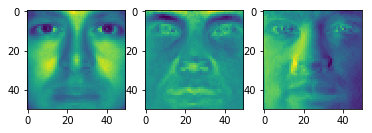

In [74]:
fig = plt.figure()
fig.add_subplot(1,3,1)
imgplot = plt.imshow(person1)
fig.add_subplot(1,3,2)
imgplot = plt.imshow(person2)
fig.add_subplot(1,3,3)
imgplot = plt.imshow(person3)
plt.show()

# Task2_2 & 2_3

In [75]:
def label(subset_num):
    """
    Input: subfolder number
    build lable vector
    subset_num: from 0 to 3
    """
    kinds = 10
    # epoch store info of stop number in each folder, like pic_start_stop in function imgMat
    epoch = np.array([7, 12, 12, 14, 19])
    label = []
    for i in range(kinds):
        label += [i+1] * epoch[subset_num]
    return label

In [84]:
t_data = imgMat(0)
t_label = label(0)

In [77]:
def knn(t_data, t_label, s_data, s_label, tran_mat, k, ignore = False):
    """
    Input: ignore: ignore first 3 singular value
    Return: error rate
    """
    if ignore == False:
        start_num = 0
    else:
        start_num = 3
    # use first k columns in transformation matrix 
    # t_data_tran is low dim data
    t_data_tran = np.dot(np.transpose(tran_mat[:, start_num:k+start_num]), t_data)
    s_data_tran = np.dot(np.transpose(tran_mat[:, start_num:k+start_num]), s_data)
    # num of train dataset
    t_data_num = t_data_tran.shape[1]
    # num of test dataset
    s_data_num = s_data_tran.shape[1]
    label = []
    # for each test data find 3 nearst neighbours
    for idx in range(s_data_num):
        # repeat test data to form the same structure as train dataset (all train images)
        s_vect_mat = np.transpose(np.tile(s_data_tran[:, idx], (t_data_num, 1)))
        # distance
        distance = np.linalg.norm((s_vect_mat - t_data_tran), axis = 0)
        # 3 nearst neighbours
        idx = np.argpartition(distance, 3)
        labels = [t_label[i] for i in idx[:3]]
        label.append(np.argmax(np.bincount(labels)))
    # return acurracy rate    
    return sum(np.equal(label, s_label))/s_data_num

In [78]:
def errRate(k, ignore = False):
    # for each folder run knn
    err_rate = np.zeros((4, k))
    for j in range(4):
        s_data = imgMat(j+1)
        s_label = label(j+1)
        for i in range(k):
            err_rate[j, i] = (knn(t_data, t_label, s_data, s_label, transform_matrix, i+1, ignore))
    # wrong name, err_rate is actually acurracy rate
    # (1 - err_rate) is the real error rate
    return 1 - err_rate

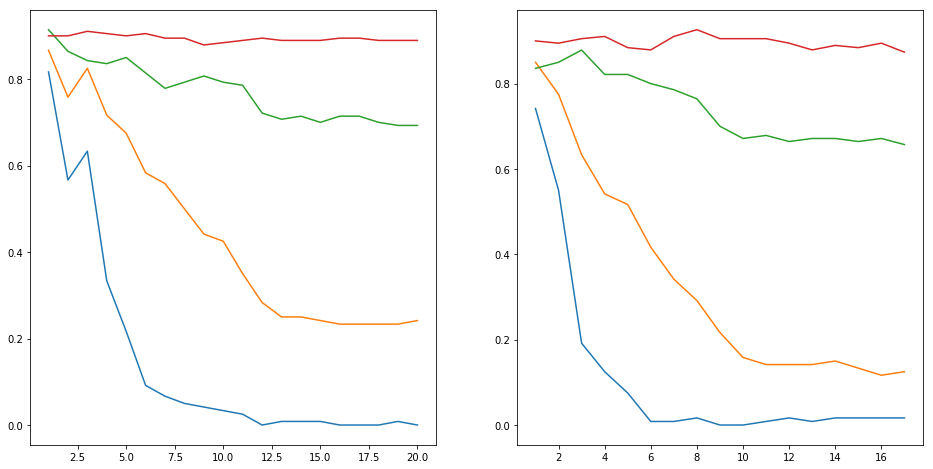

In [81]:
x1 = errRate(20)
x2 = errRate(17, True)
y1 = range(1, 21, 1)
y2 = range(1, 18, 1)
fig = plt.figure(figsize=(16, 8))
fig.add_subplot(1,2,1)
plt.plot(y1, x1[0, :], y1, x1[1, :], y1, x1[2, :], y1, x1[3, :])
fig.add_subplot(1,2,2)
plt.plot(y2, x2[0, :], y2, x2[1, :], y2, x2[2, :], y2, x2[3, :])
plt.show()

left plot is task2, and right plot is task3

**Reason:**

Actually at first I thought if we don't use info from first 3 PCs, we will get bigger error rate. But it turns out that the result is better than before. Reason for that is the first 3 PCs include infos about brightness and some infos that are not helpful to distinguish different face, and even make the result worser.